### Import Libraries

In [1]:
from ipywidgets import Output, VBox, HBox, ToggleButtons, IntSlider, Checkbox, Dropdown
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import numpy as np
import pandas as pd

### Load Dataset

In [2]:
df_raw = pd.read_csv('../data/gold_price_data.csv')

In [3]:
print("=== BASIC SHAPE & COLUMNS ===")
print("Shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())

=== BASIC SHAPE & COLUMNS ===
Shape: (5215, 7)
Columns: ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']


###  Data Dictionary

| Column         | Description                                                                        |
| -------------- | ---------------------------------------------------------------------------------- |
| **date**       | วันที่ของข้อมูล                                                                    |
| **open**       | ราคาทองคำตอนเปิดตลาด                                                               |
| **high**       | ราคาสูงสุดของวันนั้น                                                               |
| **low**        | ราคาต่ำสุดของวันนั้น                                                               |
| **close**      | ราคาปิดตลาด (ปรับสำหรับ stock split แล้ว)                                          |
| **adj\_close** | ราคาปิดตลาดที่ปรับด้วย stock splits และ dividend distributions ตามมาตรฐาน **CRSP** |
| **volume**     | ปริมาณการซื้อขาย (จำนวนหุ้นที่ถูกซื้อขายในวันนั้น)                                 |

### Summary

In [4]:
print(df_raw.dtypes)

date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object


In [5]:
print("\n=== NULL COUNTS (per column) ===")
print(df_raw.isna().sum())


=== NULL COUNTS (per column) ===
date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64


In [6]:
summary = {
    "rows": len(df_raw),
    "date_min": pd.to_datetime(df_raw['date']).min().date().isoformat(),
    "date_max": pd.to_datetime(df_raw['date']).max().date().isoformat(),
    "close_min": float(df_raw['close'].min()),
    "close_max": float(df_raw['close'].max()),
    "adj_close_min": float(df_raw['adj_close'].min()),
    "adj_close_max": float(df_raw['adj_close'].max())
}

summary


{'rows': 5215,
 'date_min': '2004-11-18',
 'date_max': '2025-08-12',
 'close_min': 41.02000045776367,
 'close_max': 315.0400085449219,
 'adj_close_min': 41.02999877929688,
 'adj_close_max': 317.489990234375}

### Clean & Index


In [7]:

# ทำสำเนา dataset
df = df_raw.copy()

# 1) แปลงคอลัมน์ date เป็น datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 2) ลบแถวที่ date ไม่สามารถแปลงได้
df = df.dropna(subset=['date'])

# 3) เรียงข้อมูลตาม date
df = df.sort_values('date').reset_index(drop=True)

# 4) ตั้ง date เป็น index
df = df.set_index('date')

# 5) กันวันที่ซ้ำ — เก็บแถวแรกไว้
df = df[~df.index.duplicated(keep='first')]

# 6) Summary เบื้องต้น
summary = {
    "rows": len(df),
    "date_min": df.index.min().date().isoformat(),
    "date_max": df.index.max().date().isoformat(),
    "close_min": float(df['close'].min()),
    "close_max": float(df['close'].max()),
    "adj_close_min": float(df['adj_close'].min()),
    "adj_close_max": float(df['adj_close'].max())
}
summary


{'rows': 5215,
 'date_min': '2004-11-18',
 'date_max': '2025-08-12',
 'close_min': 41.02000045776367,
 'close_max': 315.0400085449219,
 'adj_close_min': 41.02999877929688,
 'adj_close_max': 317.489990234375}

### Visualization: Moving Average

#### Technical Indicators

Technical Indicators เป็นเครื่องมือวิเคราะห์ทางเทคนิคที่นิยมใช้ในตลาดการเงิน
ช่วยเสริมการมองเห็นแนวโน้ม (trend), ความแรง (momentum) และความผันผวน (volatility)

---

####  Moving Average (MA)

Moving Average (MA) คือ การคำนวณค่าเฉลี่ยของราคาย้อนหลัง *N วัน* แล้วเลื่อน (rolling) ไปเรื่อย ๆ
เพื่อช่วย **ลดความผันผวนระยะสั้น (noise)** และแสดง **แนวโน้ม (trend)** ของราคาได้ชัดเจนขึ้น

---

ประเภทของ MA ที่ใช้บ่อย

* **MA50** → ค่าเฉลี่ยย้อนหลัง 50 วัน

  * ใช้ดูแนวโน้ม ระยะสั้นถึงกลาง
* **MA200** → ค่าเฉลี่ยย้อนหลัง 200 วัน

  * ใช้ดูแนวโน้ม ระยะยาว

---

การตีความ

* ถ้า MA50 > MA200 → แนวโน้มขาขึ้น (Bullish Trend)
* ถ้า MA50 < MA200 → แนวโน้มขาลง (Bearish Trend)
* จุดที่เส้น MA50 ตัดขึ้นเหนือ MA200 → เรียกว่า Golden Cross (สัญญาณเชิงบวก)
* จุดที่เส้น MA50 ตัดลงใต้ MA200 → เรียกว่า Death Cross (สัญญาณเชิงลบ)

---



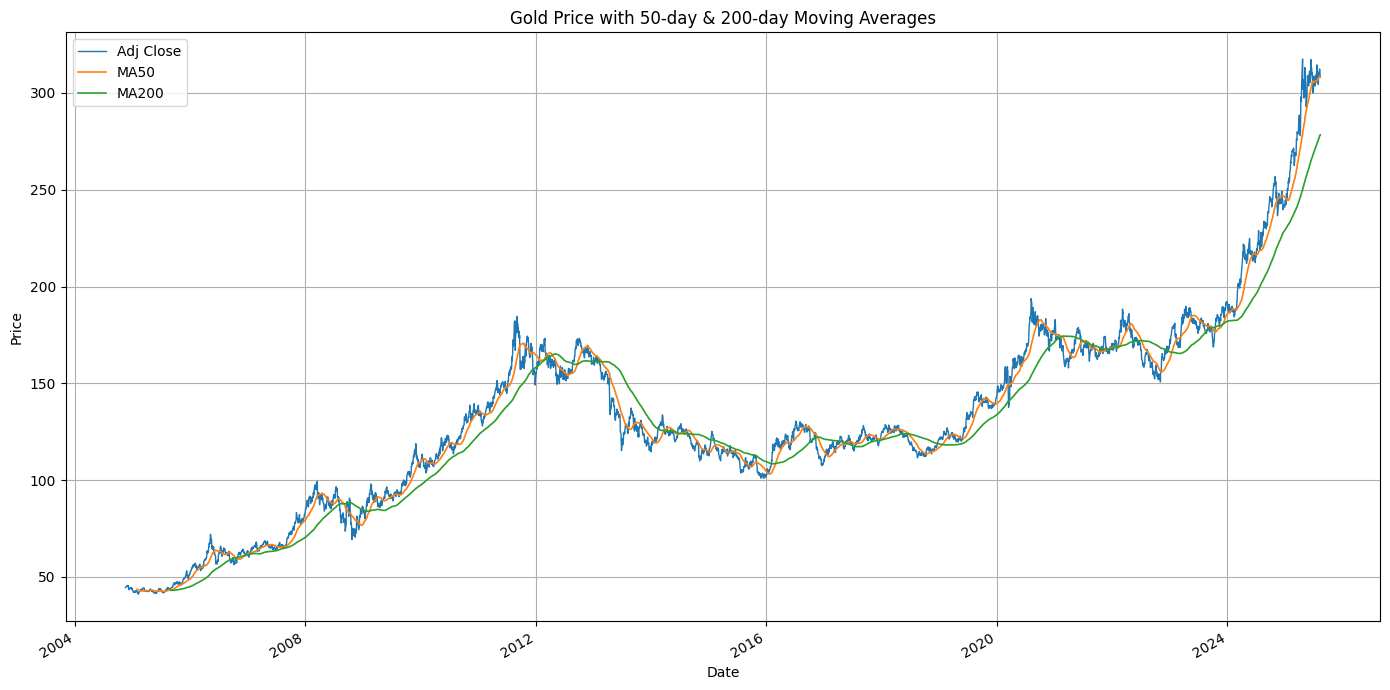

In [8]:
plt.figure(figsize=(14, 7))

# Plot ราคาปิดที่ปรับแล้ว
df['adj_close'].plot(label='Adj Close', linewidth=1)

# Plot MA50 และ MA200
df['adj_close'].rolling(50).mean().plot(label='MA50', linewidth=1.2)
df['adj_close'].rolling(200).mean().plot(label='MA200', linewidth=1.2)

plt.title('Gold Price with 50-day & 200-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


---

RSI (Relative Strength Index)

เป็นตัวชี้วัด โมเมนตัม (momentum) ของราคา
คำนวณจากการเปรียบเทียบ “การขึ้น” กับ “การลง” ของราคาย้อนหลัง (เช่น 14 วัน)
ค่าอยู่ในช่วง 0 – 100
- RSI > 70 → ตลาดอยู่ในสภาวะ Overbought (ราคาขึ้นแรงเกินไป อาจมีโอกาสปรับฐานลง)
- RSI < 30 → ตลาดอยู่ในสภาวะ Oversold (ราคาลงแรงเกินไป อาจมีโอกาสเด้งกลับขึ้น)



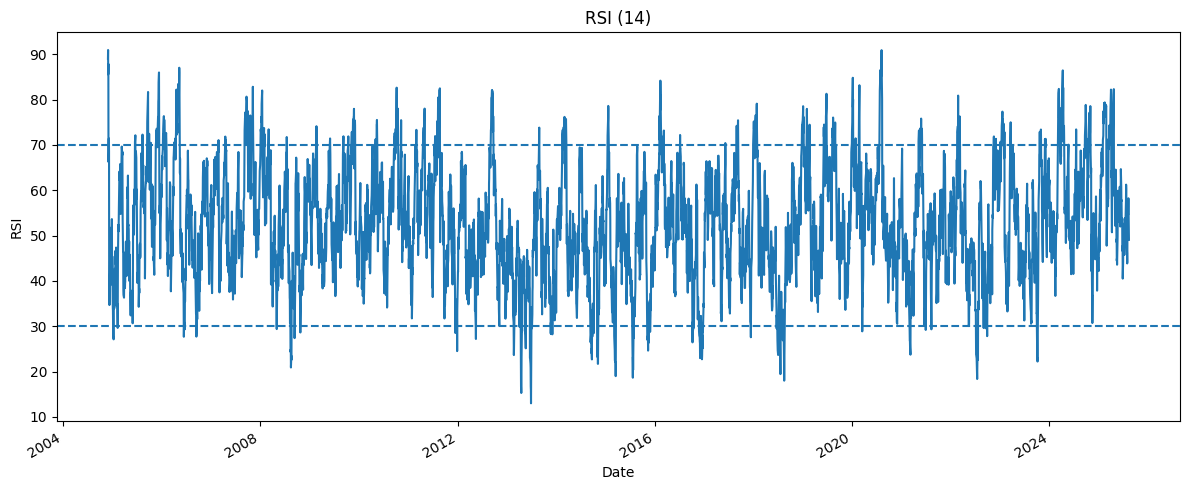

In [9]:
def compute_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Wilder’s smoothing ด้วย ewm(alpha=1/period)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi_14 = compute_rsi(df['adj_close'], period=14)

plt.figure(figsize=(12, 5))
rsi_14.plot()
plt.title('RSI (14)')
plt.xlabel('Date'); plt.ylabel('RSI')
plt.axhline(70, linestyle='--')
plt.axhline(30, linestyle='--')
plt.tight_layout(); plt.show()


#### Pivot Points 

แนวคิด : 
- ใช้ข้อมูล High / Low / Close ของรอบก่อนหน้า (เช่น วันก่อน, เดือนก่อน)
- สร้างค่าอ้างอิงชื่อว่า Pivot Point (PP)
- แล้วคำนวณแนวรับ (Support) และแนวต้าน (Resistance) เพิ่มจาก PP
- นิยมใช้เพราะ ง่ายและรวดเร็ว โดยเฉพาะในตลาดหุ้น/ฟิวเจอร์ส

---

#### สูตรคำนวณ
---
##### 1. **Pivot Point (PP)**

$$
PP = \frac{High + Low + Close}{3}
$$

เป็นค่า “จุดสมดุล” ระหว่างแรงซื้อและแรงขาย

---

##### 2. **แนวต้าน (Resistance)**

* **R1 (Resistance 1)**

$$
R1 = 2 \times PP - Low
$$

* **R2 (Resistance 2)**

$$
R2 = PP + (High - Low)
$$

---

##### 3. **แนวรับ (Support)**

* **S1 (Support 1)**

$$
S1 = 2 \times PP - High
$$

* **S2 (Support 2)**

$$
S2 = PP - (High - Low)
$$

---

##### การตีความ
* ถ้าราคาอยู่ **เหนือ PP** → มีแนวโน้มเป็น **ตลาดขาขึ้น** (bullish bias)
* ถ้าราคาอยู่ **ต่ำกว่า PP** → มีแนวโน้มเป็น **ตลาดขาลง** (bearish bias)
* **R1 / S1** = ระดับแนวต้านและแนวรับแรก → ใช้สำหรับ “จุดกลับตัว” ระยะสั้น
* **R2 / S2** = ระดับที่แรงกว่า → ถ้าราคาทะลุไปได้ อาจมีการ breakout ใหญ่

---

##### ตัวอย่าง (สมมติ)

ถ้าเดือนก่อนมีค่า:

* High = 210
* Low = 190
* Close = 200

จะได้ว่า:

* $PP = (210 + 190 + 200) / 3 = 200$
* $R1 = 2 \times 200 - 190 = 210$
* $S1 = 2 \times 200 - 210 = 190$
* $R2 = 200 + (210 - 190) = 220$
* $S2 = 200 - (210 - 190) = 180$

ดังนั้น **แนวรับ–แนวต้าน = 180, 190, 200, 210, 220**

/var/folders/2c/mfr6t_h51qd14n163lsd9vl00000gn/T/ipykernel_31807/3994695522.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df.resample('M').agg({'high':'max','low':'min','close':'last'})


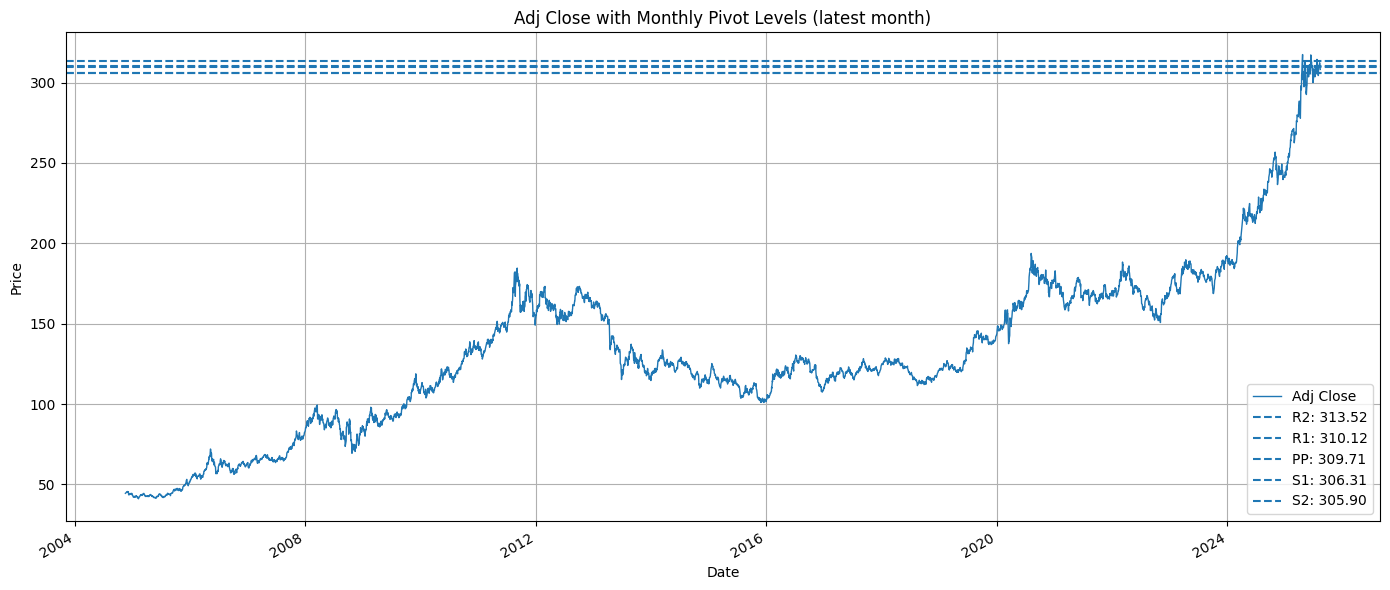

In [10]:
# Step 7B — Monthly Pivot Points (PP, S1/S2, R1/R2)
import pandas as pd
import matplotlib.pyplot as plt

# สรุป OHLC รายเดือน
m = df.resample('M').agg({'high':'max','low':'min','close':'last'})
PP = (m['high'] + m['low'] + m['close']) / 3
R1 = 2*PP - m['low']; S1 = 2*PP - m['high']
R2 = PP + (m['high'] - m['low']); S2 = PP - (m['high'] - m['low'])

# เลือก “เดือนล่าสุด” เพื่อลากเป็นระดับอ้างอิงปัจจุบัน
latest = m.index.max()
pp, r1, r2, s1, s2 = PP.loc[latest], R1.loc[latest], R2.loc[latest], S1.loc[latest], S2.loc[latest]

plt.figure(figsize=(14, 6))
df['adj_close'].plot(label='Adj Close', linewidth=1)

for level, name in [(r2,'R2'),(r1,'R1'),(pp,'PP'),(s1,'S1'),(s2,'S2')]:
    plt.axhline(level, linestyle='--', label=f'{name}: {level:.2f}')

plt.title('Adj Close with Monthly Pivot Levels (latest month)')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


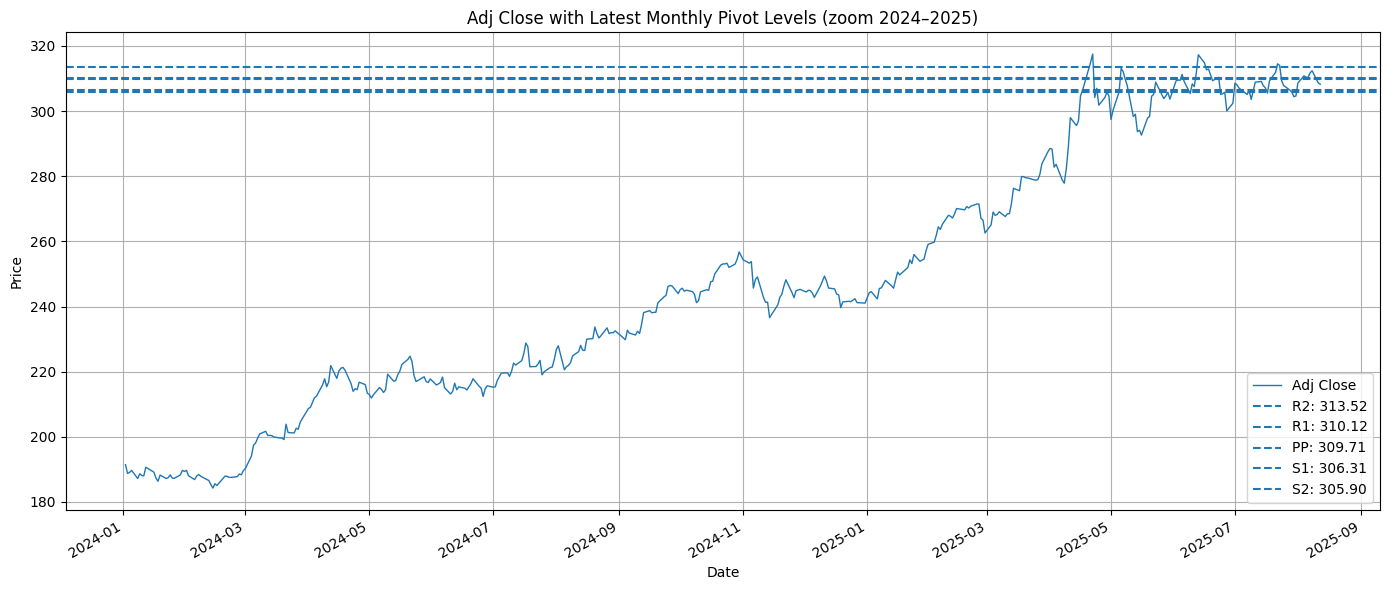

In [11]:
view = df.loc['2024':'2025']
plt.figure(figsize=(14, 6))
view['adj_close'].plot(label='Adj Close', linewidth=1)

for level, name in [(r2,'R2'),(r1,'R1'),(pp,'PP'),(s1,'S1'),(s2,'S2')]:
    plt.axhline(level, linestyle='--', label=f'{name}: {level:.2f}')

plt.title('Adj Close with Latest Monthly Pivot Levels (zoom 2024–2025)')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


### Demo

In [12]:
# ===========================
# Interactive GUI (Final)
# ===========================


# ---------- Validate df ----------
required_cols = {'open','high','low','close','adj_close'}
assert 'df' in globals(), "ต้องมีตัวแปร df (DataFrame) ที่เตรียมจาก Step 4 แล้ว"
assert required_cols.issubset(df.columns), f"df ต้องมีคอลัมน์ {required_cols}"
assert pd.api.types.is_datetime64_any_dtype(df.index), "df.index ต้องเป็น datetime"

# ---------- Helpers ----------
def compute_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain  = delta.clip(lower=0)
    loss  = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def daily_pivots(df: pd.DataFrame) -> pd.DataFrame:
    prev = df[['high','low','close']].shift(1).rename(
        columns={'high':'H_prev','low':'L_prev','close':'C_prev'}
    )
    PP = (prev['H_prev'] + prev['L_prev'] + prev['C_prev']) / 3
    R1 = 2*PP - prev['L_prev']
    S1 = 2*PP - prev['H_prev']
    R2 = PP + (prev['H_prev'] - prev['L_prev'])
    S2 = PP - (prev['H_prev'] - prev['L_prev'])
    return pd.DataFrame({'PP':PP,'R1':R1,'S1':S1,'R2':R2,'S2':S2})

def monthly_pivots(df: pd.DataFrame) -> pd.DataFrame:
    # ใช้ 'ME' (MonthEnd) แทน 'M'
    m = df.resample('ME').agg({'high':'max','low':'min','close':'last'}).dropna(how='any')
    if m.empty:
        return pd.DataFrame(index=df.index, columns=['PP','R1','S1','R2','S2'])
    PP = (m['high'] + m['low'] + m['close']) / 3
    R1 = 2*PP - m['low'];  S1 = 2*PP - m['high']
    R2 = PP + (m['high'] - m['low']);  S2 = PP - (m['high'] - m['low'])
    piv_m = pd.DataFrame({'PP':PP,'R1':R1,'S1':S1,'R2':R2,'S2':S2})
    # กระจายเป็นรายวันแบบ step แล้ว align กับวันทำการจริง
    piv_daily   = piv_m.reindex(df.resample('D').asfreq().index, method='ffill')
    piv_aligned = piv_daily.reindex(df.index, method='ffill')
    return piv_aligned

def plot_candles(data: pd.DataFrame, ax=None, width=None):
    """
    วาดแท่งเทียนจากคอลัมน์ open, high, low, close
    ปรับความกว้างแท่งตามช่องว่างวันที่ (dynamic width)
    """
    if ax is None:
        ax = plt.gca()
    x = mdates.date2num(data.index.to_pydatetime())
    if width is None:
        if len(x) > 1:
            spacing = np.diff(x)
            width = np.median(spacing) * 0.8
        else:
            width = 0.6

    for xi, o, h, l, c in zip(x, data['open'], data['high'], data['low'], data['close']):
        ax.vlines(xi, l, h, linewidth=1)
        up = c >= o
        lower  = o if up else c
        height = (c - o) if up else (o - c)
        if height == 0:
            height = 1e-6  # doji
        color = 'green' if up else 'red'
        rect = patches.Rectangle((xi - width/2, lower), width, height, facecolor=color, edgecolor=color, linewidth=1)
        ax.add_patch(rect)

    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    ax.set_xlim(x.min()-width, x.max()+width)
    ax.grid(True)
    return ax

# ---------- Widgets ----------
view_selector = ToggleButtons(
    options=[('MA','ma'), ('RSI','rsi'), ('Pivot','pivot')],
    value='ma',
    description='View:',
)

last_n = IntSlider(value=180, min=60, max=1000, step=10, description='Last N days')

# MA
ma_short = IntSlider(value=50,  min=5,  max=150, step=1, description='MA short')
ma_long  = IntSlider(value=200, min=20, max=300, step=5, description='MA long')
ma_show_cross = Checkbox(value=False, description='Show cross markers')

# RSI
rsi_period = IntSlider(value=14, min=5, max=50, step=1, description='RSI period')

# Pivot
pivot_type   = ToggleButtons(options=[('Daily','daily'), ('Monthly','monthly')], value='daily', description='Pivot:')
pivot_style  = ToggleButtons(options=[('Line','line'), ('Candles','candles')], value='line', description='Pivot style:')
pivot_levels = Dropdown(options=[('PP-R1-S1','pp_r1_s1'), ('PP–R2–S2','pp_r2_s2')], value='pp_r1_s1', description='Levels:')

# Candles overlay (ใช้ใน Pivot style = Candles)
overlay_ma_on_candle = Checkbox(value=True, description='Overlay MA on Candles')

# Layout groups
def set_display(widget, show: bool):
    widget.layout.display = '' if show else 'none'

row_top  = HBox([view_selector, last_n])
row_ma   = HBox([ma_short, ma_long, ma_show_cross])
row_rsi  = HBox([rsi_period])
row_piv  = HBox([pivot_type, pivot_style, pivot_levels])
row_cndl = HBox([overlay_ma_on_candle])

controls = VBox([row_top, row_ma, row_rsi, row_piv, row_cndl])

def update_visibility(view_value: str):
    # MA controls: ใช้ในโหมด MA และใน Pivot เมื่อพื้นหลังเป็น Candles (เพื่อปรับ MA overlay)
    set_display(row_ma, view_value == 'ma' or (view_value == 'pivot' and pivot_style.value == 'candles'))
    set_display(row_rsi, view_value == 'rsi')
    set_display(row_piv, view_value == 'pivot')
    is_candle_context = (view_value == 'pivot' and pivot_style.value == 'candles')
    set_display(row_cndl, is_candle_context)

# ---------- Output ----------
out = Output()

# ---------- Plotting ----------
def update_plot(*_):
    with out:
        clear_output(wait=True)
        data = df.iloc[-last_n.value:].copy()

        if view_selector.value == 'ma':
            plt.figure(figsize=(14,6))
            data['adj_close'].plot(label='Adj Close', linewidth=1)

            fast = data['adj_close'].rolling(ma_short.value).mean()
            slow = data['adj_close'].rolling(ma_long.value).mean()
            fast.plot(label=f'MA{ma_short.value}', linewidth=1.2)
            slow.plot(label=f'MA{ma_long.value}',  linewidth=1.2)

            if ma_show_cross.value:
                mask = fast.notna() & slow.notna()
                cross_up = mask & (fast > slow) & (fast.shift(1) <= slow.shift(1))
                cross_dn = mask & (fast < slow) & (fast.shift(1) >= slow.shift(1))
                plt.scatter(data.index[cross_up], data['adj_close'][cross_up], marker='^')
                plt.scatter(data.index[cross_dn], data['adj_close'][cross_dn], marker='v')

            plt.title('Adj Close with Moving Averages')
            plt.xlabel('Date'); plt.ylabel('Price')
            plt.legend(); plt.tight_layout(); plt.show()
            return

        if view_selector.value == 'rsi':
            plt.figure(figsize=(14,4))
            rsi = compute_rsi(data['adj_close'], rsi_period.value)
            rsi.plot()
            plt.title(f'RSI ({rsi_period.value})')
            plt.xlabel('Date'); plt.ylabel('RSI')
            plt.axhline(70, linestyle='--'); plt.axhline(30, linestyle='--')
            plt.tight_layout(); plt.show()
            return

        if view_selector.value == 'pivot':
            fig, ax = plt.subplots(figsize=(14,6))

            # พื้นหลัง: line หรือ candles
            if pivot_style.value == 'line':
                data['adj_close'].plot(ax=ax, label='Adj Close', linewidth=1)
            else:
                plot_candles(data, ax=ax, width=None)
                if overlay_ma_on_candle.value:
                    fast = data['adj_close'].rolling(ma_short.value).mean()
                    slow = data['adj_close'].rolling(ma_long.value).mean()
                    fast.plot(ax=ax, linewidth=1.2, label=f'MA{ma_short.value}')
                    slow.plot(ax=ax, linewidth=1.2, label=f'MA{ma_long.value}')

            # คำนวณ Pivot (align กับช่วงที่แสดง)
            piv = daily_pivots(df).reindex(data.index) if pivot_type.value == 'daily' else monthly_pivots(df).reindex(data.index)
            cols = ['PP','R1','S1'] if pivot_levels.value == 'pp_r1_s1' else ['PP','R1','S1','R2','S2']
            for c in cols:
                piv[c].plot(ax=ax, drawstyle='steps-post', linestyle='--', label=c)

            ax.set_title(f"Pivot ({pivot_type.value.capitalize()}) — style: {pivot_style.value.capitalize()}")
            ax.set_xlabel('Date'); ax.set_ylabel('Price')
            ax.legend(); plt.tight_layout(); plt.show()
            return

def on_view_change(change):
    if change['name'] == 'value':
        update_visibility(change['new'])
        update_plot()

def on_pivot_style_change(change):
    if change['name'] == 'value':
        update_visibility(view_selector.value)
        update_plot()

# ---------- Wire events ----------
for w in [last_n, ma_short, ma_long, ma_show_cross, rsi_period, pivot_type, pivot_levels, overlay_ma_on_candle]:
    # w.observe(update_plot, names='value')
    w.observe(lambda ch: update_plot(), names='value')

pivot_style.observe(on_pivot_style_change, names='value')
view_selector.observe(on_view_change, names='value')

# ---------- Initial render ----------
update_visibility(view_selector.value)
update_plot()
display(controls, out)


Output()

### Demo : AI

#### Forecast

In [13]:
# Step 10.1 — เตรียมฟีเจอร์ (Features) จาก MA, RSI, Pivot

import numpy as np
import pandas as pd

# สมมติว่ามี compute_rsi() และ daily_pivots() แล้วจากก่อนหน้า
feat = pd.DataFrame(index=df.index)
price = df['adj_close'].copy()

# --- Targets: next-day return ---
feat['ret_1d']   = price.pct_change(1)                   # ใช้เป็นฟีเจอร์
y_next_ret       = price.pct_change(1).shift(-1)         # เป้าหมาย: ผลตอบแทนวันถัดไป

# --- MA ratios ---
ma_fast_win = 50
ma_slow_win = 200
ma_fast = price.rolling(ma_fast_win).mean()
ma_slow = price.rolling(ma_slow_win).mean()
feat['ma_fast_ratio'] = price / ma_fast
feat['ma_slow_ratio'] = price / ma_slow

# --- RSI ---
feat['rsi_14'] = compute_rsi(price, 14)

# --- Pivot (daily) จาก "วันก่อนหน้า" ปลอด look-ahead ---
piv = daily_pivots(df).reindex(df.index)
for col in ['PP','R1','S1']:
    feat[f'dist_{col}'] = (price - piv[col]) / price  # ระยะห่างเชิงสัดส่วน

# --- Lags (หน่วงเวลา) เพิ่มความนิ่งของโมเดล ---
feat['ret_1d_lag1'] = feat['ret_1d'].shift(1)
feat['rsi_lag1']    = feat['rsi_14'].shift(1)
feat['ma_fast_lag1'] = feat['ma_fast_ratio'].shift(1)
feat['ma_slow_lag1'] = feat['ma_slow_ratio'].shift(1)

# รวม target + ทำความสะอาด
data_ml = pd.concat([feat, y_next_ret.rename('y_next_ret')], axis=1).dropna()
data_ml.tail()


,ret_1d,ma_fast_ratio,ma_slow_ratio,rsi_14,dist_PP,dist_R1,dist_S1,ret_1d_lag1,rsi_lag1,ma_fast_lag1,ma_slow_lag1,y_next_ret
date,,,,,,,,,,,,
2025-08-05,-0.001384,1.007387,1.120957,54.690476,-0.002051,0.000311,-0.002363,0.007096,55.559935,1.009128,1.123837,-0.000161
2025-08-06,-0.000161,1.007129,1.119509,54.583537,-0.002857,0.000473,-0.003008,-0.001384,54.690476,1.007387,1.120957,0.004511
2025-08-07,0.004511,1.011153,1.123264,57.112830,0.003828,0.006117,0.003743,-0.000161,54.583537,1.007129,1.119509,0.002021
2025-08-08,0.002021,1.012691,1.124271,58.239898,0.000096,0.002721,0.002657,0.004511,57.112830,1.011153,1.123264,-0.011942
2025-08-11,-0.011942,1.000410,1.109729,49.881667,-0.012659,-0.009407,-0.010963,0.002021,58.239898,1.012691,1.124271,-0.001296


In [14]:
# Step 10.2 — แบ่ง Train/Test แบบ Time-based

from datetime import timedelta

# กำหนด "ระยะทดสอบ" = 365 วันล่าสุด (ปรับได้)
test_days = 365
cutoff = data_ml.index.max() - pd.Timedelta(days=test_days)

train = data_ml.loc[:cutoff].copy()
test  = data_ml.loc[cutoff:].copy()

X_train = train.drop(columns=['y_next_ret'])
y_train = train['y_next_ret']
X_test  = test.drop(columns=['y_next_ret'])
y_test  = test['y_next_ret']

len(train), len(test), cutoff


(4764, 250, Timestamp('2024-08-11 00:00:00'))

In [15]:
# Step 10.3 — เทรนโมเดล Ridge (scaled) และประเมินผล

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', Ridge(alpha=1.0, random_state=42))
])

model.fit(X_train, y_train)

pred_test = model.predict(X_test)

mae  = mean_absolute_error(y_test, pred_test)
rmse = mean_squared_error(y_test, pred_test, squared=False)
r2   = r2_score(y_test, pred_test)

print("=== Test Metrics (next-day return) ===")
print(f"MAE : {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R^2 : {r2:.4f}")


=== Test Metrics (next-day return) ===
MAE : 0.007252
RMSE: 0.009921
R^2 : -0.0067


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


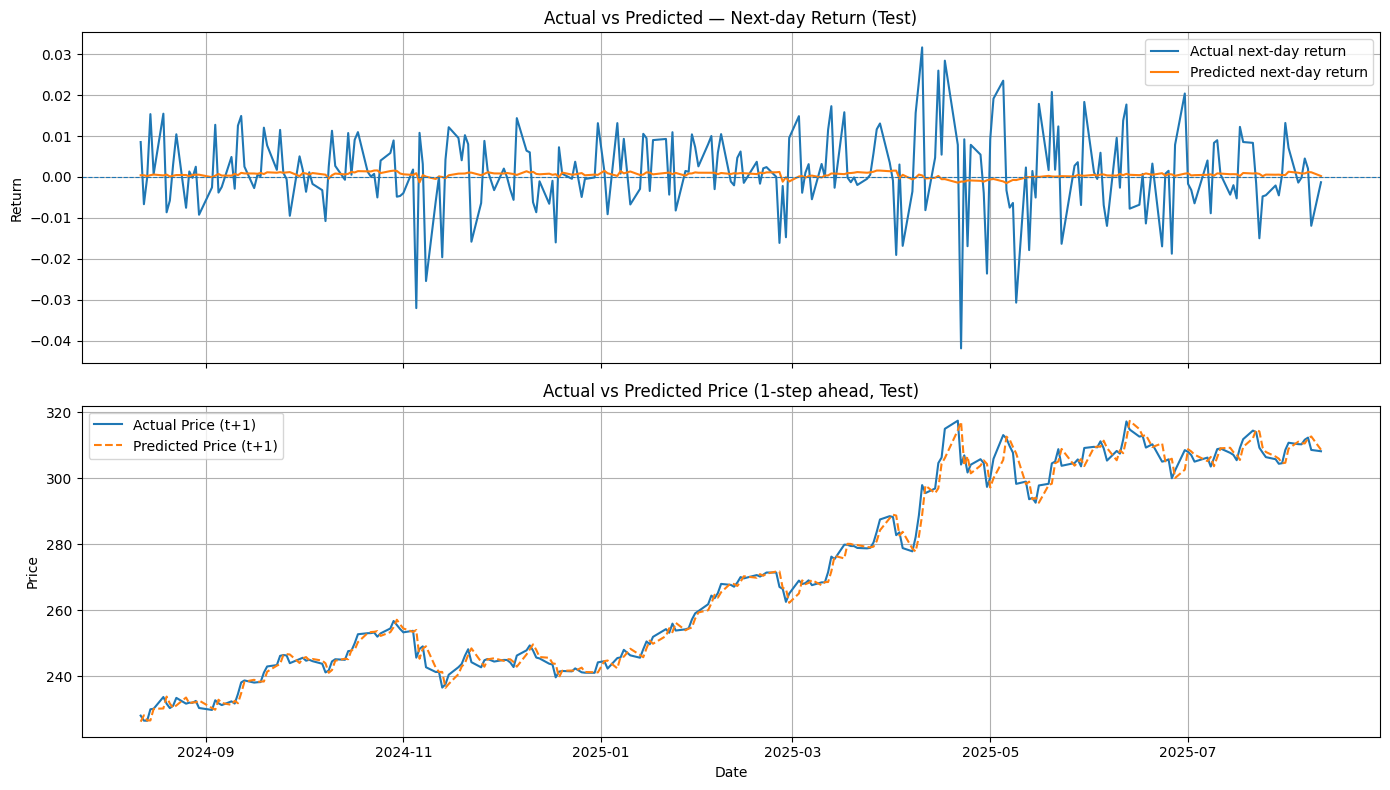

In [16]:
# Step 10.4 — พล็อต Actual vs Predicted (ช่วงทดสอบ) แบบไม่เจอ KeyError

import matplotlib.pyplot as plt

# index ของช่วงทดสอบ (วันเทรดจริง ๆ ใน X_test)
idx = X_test.index

# ผลตอบแทนทำนาย/จริง (จัด index ให้ตรงกับ X_test)
pred_ret = pd.Series(pred_test, index=idx, name='pred_ret')
actual_next_ret = y_test.reindex(idx)

# ราคาที่ t (ใช้ reindex ป้องกันวันที่หาย)
price_t = price.reindex(idx)

# ราคาจริงที่ t+1 (เลื่อน -1 วัน แล้ว reindex ให้ตรงกับ idx ของ t)
price_tp1_actual = price.shift(-1).reindex(idx)

# ราคาทำนายที่ t+1: P_{t+1}^{pred} = P_t * (1 + r_{t+1}^{pred})
price_tp1_pred = price_t * (1 + pred_ret)

# (ออปชัน) ย้ายเส้น “ราคาทำนาย t+1” ไป plot ที่แกนเวลา t+1 ให้ตรงตำแหน่งกับราคาจริง t+1
price_tp1_pred_for_plot = price_tp1_pred.copy()
price_tp1_pred_for_plot.index = price_tp1_actual.index  # ให้ overlay กันสวย ๆ

# วาดกราฟ
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 1) ผลตอบแทน (ทดสอบ)
axes[0].plot(actual_next_ret.index, actual_next_ret.values, label='Actual next-day return')
axes[0].plot(pred_ret.index,      pred_ret.values,      label='Predicted next-day return')
axes[0].axhline(0, linestyle='--', linewidth=0.8)
axes[0].set_title('Actual vs Predicted — Next-day Return (Test)')
axes[0].set_ylabel('Return')
axes[0].legend(); axes[0].grid(True)

# 2) ราคา (overlay ราคา t+1 จริง กับ t+1 ที่ทำนาย)
axes[1].plot(price_tp1_actual.index, price_tp1_actual.values, label='Actual Price (t+1)')
axes[1].plot(price_tp1_pred_for_plot.index, price_tp1_pred_for_plot.values,
             label='Predicted Price (t+1)', linestyle='--')
axes[1].set_title('Actual vs Predicted Price (1-step ahead, Test)')
axes[1].set_xlabel('Date'); axes[1].set_ylabel('Price')
axes[1].legend(); axes[1].grid(True)

plt.tight_layout(); plt.show()


#### Detection signal Buy and Sell

In [17]:
import pandas as pd
import numpy as np

price = df['adj_close'].copy()

horizon = 3   # ระยะมองล่วงหน้า 3 วัน (ปรับได้)
band = 0.005  # deadzone 0.5%

fwd_5d = price.shift(-horizon) / price - 1.0

def to_label(r):
    if r >  band:  return 'Up'
    if r < -band:  return 'Down'
    return 'Hold'

y = fwd_5d.apply(to_label)
y.name = 'signal_5d'
y.value_counts().sort_index()


signal_5d
Down    1779
Hold    1292
Up      2144
Name: count, dtype: int64

In [18]:
feat = pd.DataFrame(index=df.index)
feat['ret_1d'] = price.pct_change(1)

# MA
ma_fast_win = 50
ma_slow_win = 200
ma_fast = price.rolling(ma_fast_win).mean()
ma_slow = price.rolling(ma_slow_win).mean()
feat['ma_fast_ratio'] = price / ma_fast
feat['ma_slow_ratio'] = price / ma_slow

# RSI
feat['rsi_14'] = compute_rsi(price, 14)

# Pivot (previous day)
piv = daily_pivots(df).reindex(df.index)
for col in ['PP','R1','S1']:
    feat[f'dist_{col}'] = (price - piv[col]) / price

# Lags
feat['ret_1d_lag1']    = feat['ret_1d'].shift(1)
feat['rsi_lag1']       = feat['rsi_14'].shift(1)
feat['ma_fast_lag1']   = feat['ma_fast_ratio'].shift(1)
feat['ma_slow_lag1']   = feat['ma_slow_ratio'].shift(1)

# รวม X, y และล้าง NaN
data_cls = pd.concat([feat, y], axis=1).dropna()
X = data_cls.drop(columns=[y.name])
y_cls = data_cls[y.name]
X.tail(), y_cls.tail()

(              ret_1d  ma_fast_ratio  ma_slow_ratio     rsi_14   dist_PP  \
 date                                                                      
 2025-08-06 -0.000161       1.007129       1.119509  54.583537 -0.002857   
 2025-08-07  0.004511       1.011153       1.123264  57.112830  0.003828   
 2025-08-08  0.002021       1.012691       1.124271  58.239898  0.000096   
 2025-08-11 -0.011942       1.000410       1.109729  49.881667 -0.012659   
 2025-08-12 -0.001296       0.998817       1.107193  49.068418 -0.001276   
 
              dist_R1   dist_S1  ret_1d_lag1   rsi_lag1  ma_fast_lag1  \
 date                                                                   
 2025-08-06  0.000473 -0.003008    -0.001384  54.690476      1.007387   
 2025-08-07  0.006117  0.003743    -0.000161  54.583537      1.007129   
 2025-08-08  0.002721  0.002657     0.004511  57.112830      1.011153   
 2025-08-11 -0.009407 -0.010963     0.002021  58.239898      1.012691   
 2025-08-12  0.002120 -0.001

In [26]:
df.shape

(5215, 6)

In [31]:
# test_days = 365
test_days = 5000
cutoff = X.index.max() - pd.Timedelta(days=test_days)

X_train, y_train = X.loc[:cutoff], y_cls.loc[:cutoff]
X_test,  y_test  = X.loc[cutoff:], y_cls.loc[cutoff:]

len(X_train), len(X_test), cutoff


(1574, 3441, Timestamp('2011-12-04 00:00:00'))

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)

print("Accuracy (test):", accuracy_score(y_test, pred))
print("\nClassification report\n", classification_report(y_test, pred))
print("\nConfusion matrix\n", confusion_matrix(y_test, pred, labels=['Down','Hold','Up']))


Accuracy (test): 0.37053182214472535

Classification report
               precision    recall  f1-score   support

        Down       0.36      0.18      0.24      1181
        Hold       0.32      0.02      0.04       957
          Up       0.37      0.80      0.51      1303

    accuracy                           0.37      3441
   macro avg       0.35      0.33      0.26      3441
weighted avg       0.35      0.37      0.29      3441


Confusion matrix
 [[ 211   19  951]
 [ 146   23  788]
 [ 231   31 1041]]


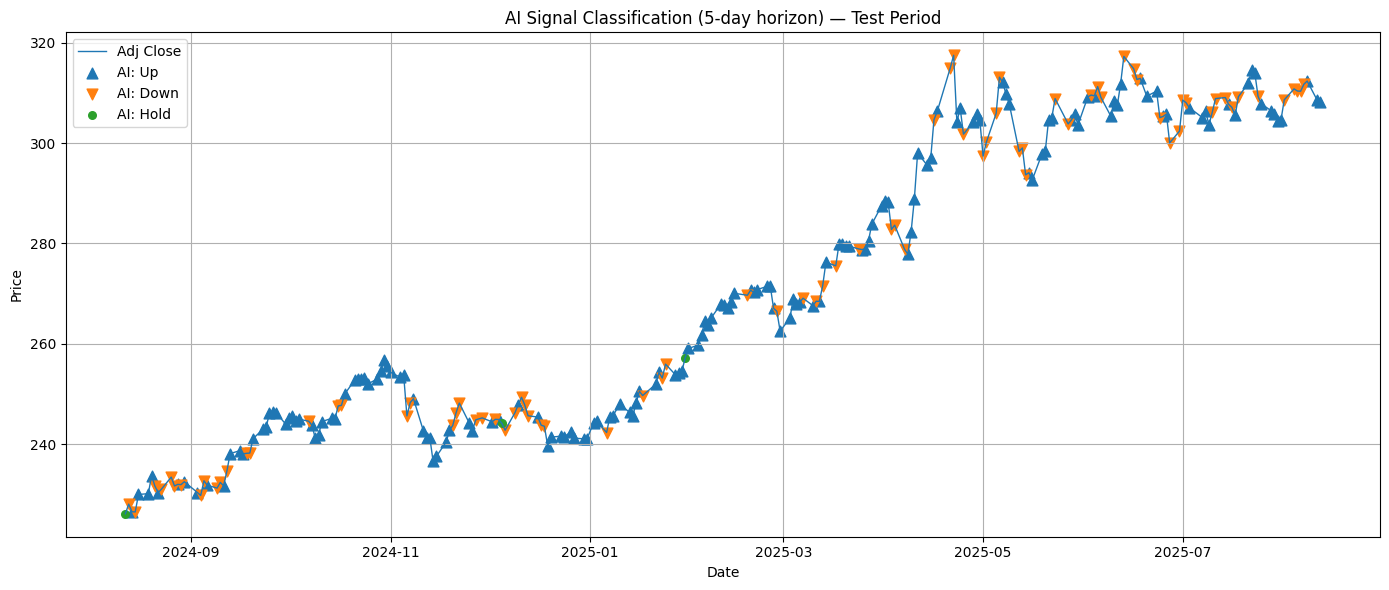

In [21]:
import matplotlib.pyplot as plt

test_idx = X_test.index
price_view = price.reindex(test_idx)

plt.figure(figsize=(14,6))
plt.plot(price_view.index, price_view.values, label='Adj Close', linewidth=1)

mask_up   = (pred == 'Up')
mask_dn   = (pred == 'Down')
mask_hold = (pred == 'Hold')

# วาง marker (ใช้ y = ราคาปิด ณ วันตัดสินใจ)
plt.scatter(test_idx[mask_up],   price_view[mask_up],   marker='^', s=60, label='AI: Up')
plt.scatter(test_idx[mask_dn],   price_view[mask_dn],   marker='v', s=60, label='AI: Down')
plt.scatter(test_idx[mask_hold], price_view[mask_hold], marker='o', s=30, label='AI: Hold')

plt.title('AI Signal Classification (5-day horizon) — Test Period')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [22]:
# ===========================
# GUI + AI Signals (Classification)
# ===========================
from ipywidgets import Output, VBox, HBox, ToggleButtons, IntSlider, FloatSlider, Checkbox, Dropdown, Button, HTML
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------- Validate df ----------
required_cols = {'open','high','low','close','adj_close'}
assert 'df' in globals(), "ต้องมีตัวแปร df (DataFrame) ที่เตรียมจาก Step 4 แล้ว"
assert required_cols.issubset(df.columns), f"df ต้องมีคอลัมน์ {required_cols}"
assert pd.api.types.is_datetime64_any_dtype(df.index), "df.index ต้องเป็น datetime"

price = df['adj_close']

# ---------- Widgets (จาก GUI เดิม) ----------
view_selector = ToggleButtons(options=[('MA','ma'), ('RSI','rsi'), ('Pivot','pivot')], value='ma', description='View:')
last_n  = IntSlider(value=180, min=60, max=1000, step=10, description='Last N days')

# MA
ma_short = IntSlider(value=50,  min=5,  max=150, step=1, description='MA short')
ma_long  = IntSlider(value=200, min=20, max=300, step=5, description='MA long')
ma_show_cross = Checkbox(value=False, description='Show cross markers')

# RSI
rsi_period = IntSlider(value=14, min=5, max=50, step=1, description='RSI period')

# Pivot
pivot_type   = ToggleButtons(options=[('Daily','daily'), ('Monthly','monthly')], value='daily', description='Pivot:')
pivot_style  = ToggleButtons(options=[('Line','line'), ('Candles','candles')], value='line', description='Pivot style:')
pivot_levels = Dropdown(options=[('PP,R1,S1','pp_r1_s1'), ('PP–R2–S2','pp_r2_s2')], value='pp_r1_s1', description='Levels:')
overlay_ma_on_candle = Checkbox(value=True, description='Overlay MA on Candles')

# ---------- AI widgets ----------
ai_enable   = Checkbox(value=True, description='AI Signals')
ai_horizon  = IntSlider(value=5, min=3, max=30, step=1, description='Horizon (days)')
ai_band     = FloatSlider(value=0.005, min=0.001, max=0.02, step=0.001, readout_format='.3f', description='Deadzone')
ai_testdays = IntSlider(value=365, min=120, max=1000, step=5, description='Test days')
ai_train_btn = Button(description='Train / Retrain', button_style='info')
ai_status   = HTML(value="")

# ---------- Layout ----------
def set_display(widget, show: bool):
    widget.layout.display = '' if show else 'none'

row_top  = HBox([view_selector, last_n, ai_enable])
row_ma   = HBox([ma_short, ma_long, ma_show_cross])
row_rsi  = HBox([rsi_period])
row_piv  = HBox([pivot_type, pivot_style, pivot_levels, overlay_ma_on_candle])

row_ai1  = HBox([ai_horizon, ai_band, ai_testdays, ai_train_btn])
row_ai2  = HBox([ai_status])

controls = VBox([row_top, row_ma, row_rsi, row_piv, row_ai1, row_ai2])

def update_visibility(view_value: str):
    set_display(row_ma, view_value == 'ma' or (view_value == 'pivot' and pivot_style.value == 'candles'))
    set_display(row_rsi, view_value == 'rsi')
    set_display(row_piv, view_value == 'pivot')
    set_display(row_ai1, ai_enable.value)
    set_display(row_ai2, ai_enable.value)
    # overlay MA controls เฉพาะ Pivot+candles
    set_display(overlay_ma_on_candle, view_value == 'pivot' and pivot_style.value == 'candles')

# ---------- Feature & Label builders ----------
def build_features(df_: pd.DataFrame) -> pd.DataFrame:
    p = df_['adj_close']
    feat = pd.DataFrame(index=df_.index)
    # return & MA ratios
    feat['ret_1d'] = p.pct_change(1)
    ma_fast = p.rolling(50).mean()
    ma_slow = p.rolling(200).mean()
    feat['ma_fast_ratio'] = p / ma_fast
    feat['ma_slow_ratio'] = p / ma_slow
    # RSI
    feat['rsi_14'] = compute_rsi(p, 14)
    # Pivot (prev day)
    piv = daily_pivots(df_).reindex(df_.index)
    for col in ['PP','R1','S1']:
        feat[f'dist_{col}'] = (p - piv[col]) / p
    # Lags
    feat['ret_1d_lag1']   = feat['ret_1d'].shift(1)
    feat['rsi_lag1']      = feat['rsi_14'].shift(1)
    feat['ma_fast_lag1']  = feat['ma_fast_ratio'].shift(1)
    feat['ma_slow_lag1']  = feat['ma_slow_ratio'].shift(1)
    return feat

def make_labels(p: pd.Series, horizon: int, band: float) -> pd.Series:
    fwd = p.shift(-horizon) / p - 1.0
    def to_label(r):
        if r >  band:  return 'Up'
        if r < -band:  return 'Down'
        return 'Hold'
    y = fwd.apply(to_label)
    y.name = f'signal_{horizon}d'
    return y

# ---------- AI state ----------
_ai_model = None
_ai_pred  = None
_ai_idx   = None
_ai_report = ""
_ai_conf   = None

def train_ai(*_):
    global _ai_model, _ai_pred, _ai_idx, _ai_report, _ai_conf
    ai_status.value = "<span>Training…</span>"
    feat = build_features(df)
    y    = make_labels(price, ai_horizon.value, ai_band.value)
    data = pd.concat([feat, y], axis=1).dropna()
    if data.empty:
        ai_status.value = "<b style='color:red'>Not enough data after feature engineering.</b>"
        return
    X = data.drop(columns=[y.name])
    y_cls = data[y.name]

    cutoff = X.index.max() - pd.Timedelta(days=ai_testdays.value)
    X_train, y_train = X.loc[:cutoff], y_cls.loc[:cutoff]
    X_test,  y_test  = X.loc[cutoff:], y_cls.loc[cutoff:]
    if len(X_train) < 100 or len(X_test) < 20:
        ai_status.value = "<b style='color:red'>Train/Test split too small. Adjust test days.</b>"
        return

    clf = RandomForestClassifier(n_estimators=300, min_samples_leaf=3, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)

    acc = accuracy_score(y_test, pred)
    _ai_report = classification_report(y_test, pred, zero_division=0)
    _ai_conf   = confusion_matrix(y_test, pred, labels=['Down','Hold','Up'])

    _ai_model = clf
    _ai_pred  = pd.Series(pred, index=X_test.index, name='ai_signal')
    _ai_idx   = X_test.index

    ai_status.value = f"<b>Trained.</b> Test Accuracy: {acc:.3f}"
    update_plot()

# ---------- Output ----------
out = Output()

# ---------- Plot ----------
def update_plot(*_):
    with out:
        clear_output(wait=True)
        data = df.iloc[-last_n.value:].copy()

        if view_selector.value == 'ma':
            plt.figure(figsize=(14,6))
            data['adj_close'].plot(label='Adj Close', linewidth=1)

            fast = data['adj_close'].rolling(ma_short.value).mean()
            slow = data['adj_close'].rolling(ma_long.value).mean()
            fast.plot(label=f'MA{ma_short.value}', linewidth=1.2)
            slow.plot(label=f'MA{ma_long.value}',  linewidth=1.2)

            if ma_show_cross.value:
                mask = fast.notna() & slow.notna()
                cross_up = mask & (fast > slow) & (fast.shift(1) <= slow.shift(1))
                cross_dn = mask & (fast < slow) & (fast.shift(1) >= slow.shift(1))
                plt.scatter(data.index[cross_up], data['adj_close'][cross_up], marker='^')
                plt.scatter(data.index[cross_dn], data['adj_close'][cross_dn], marker='v')

            # AI markers (ถ้าเปิดและมีโมเดลแล้ว)
            if ai_enable.value and _ai_pred is not None:
                idx = data.index.intersection(_ai_pred.index)
                if len(idx) > 0:
                    sig = _ai_pred.reindex(idx)
                    yv = data.loc[idx, 'adj_close']
                    plt.scatter(idx[sig.eq('Up')],   yv[sig.eq('Up')],   marker='^', s=60, label='AI: Up')
                    plt.scatter(idx[sig.eq('Down')], yv[sig.eq('Down')], marker='v', s=60, label='AI: Down')
                    plt.scatter(idx[sig.eq('Hold')], yv[sig.eq('Hold')], marker='o', s=35, label='AI: Hold')

            plt.title('Adj Close with Moving Averages')
            plt.xlabel('Date'); plt.ylabel('Price')
            plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
            return

        if view_selector.value == 'rsi':
            plt.figure(figsize=(14,4))
            rsi = compute_rsi(data['adj_close'], rsi_period.value)
            rsi.plot()
            plt.title(f'RSI ({rsi_period.value})')
            plt.xlabel('Date'); plt.ylabel('RSI')
            plt.axhline(70, linestyle='--'); plt.axhline(30, linestyle='--')
            plt.tight_layout(); plt.show()
            return

        if view_selector.value == 'pivot':
            fig, ax = plt.subplots(figsize=(14,6))

            # พื้นหลัง: line หรือ candles
            if pivot_style.value == 'line':
                data['adj_close'].plot(ax=ax, label='Adj Close', linewidth=1)
            else:
                plot_candles(data, ax=ax, width=None)
                if overlay_ma_on_candle.value:
                    fast = data['adj_close'].rolling(ma_short.value).mean()
                    slow = data['adj_close'].rolling(ma_long.value).mean()
                    fast.plot(ax=ax, linewidth=1.2, label=f'MA{ma_short.value}')
                    slow.plot(ax=ax, linewidth=1.2, label=f'MA{ma_long.value}')

            # Pivot lines
            piv = daily_pivots(df).reindex(data.index) if pivot_type.value == 'daily' else monthly_pivots(df).reindex(data.index)
            cols = ['PP','R1','S1'] if pivot_levels.value == 'pp_r1_s1' else ['PP','R1','S1','R2','S2']
            for c in cols:
                piv[c].plot(ax=ax, drawstyle='steps-post', linestyle='--', label=c)

            # AI markers
            if ai_enable.value and _ai_pred is not None:
                idx = data.index.intersection(_ai_pred.index)
                if len(idx) > 0:
                    sig = _ai_pred.reindex(idx)
                    yv = data.loc[idx, 'adj_close']
                    ax.scatter(idx[sig.eq('Up')],   yv[sig.eq('Up')],   marker='^', s=60, label='AI: Up')
                    ax.scatter(idx[sig.eq('Down')], yv[sig.eq('Down')], marker='v', s=60, label='AI: Down')
                    ax.scatter(idx[sig.eq('Hold')], yv[sig.eq('Hold')], marker='o', s=35, label='AI: Hold')

            ax.set_title(f"Pivot ({pivot_type.value.capitalize()}) — style: {pivot_style.value.capitalize()}")
            ax.set_xlabel('Date'); ax.set_ylabel('Price')
            ax.legend(); ax.grid(True); plt.tight_layout(); plt.show()
            return

# ---------- Visibility & Events ----------
def on_view_change(change):
    if change['name'] == 'value':
        update_visibility(change['new'])
        update_plot()

def on_pivot_style_change(change):
    if change['name'] == 'value':
        update_visibility(view_selector.value)
        update_plot()

def on_ai_enable(change):
    if change['name'] == 'value':
        update_visibility(view_selector.value)
        update_plot()

ai_train_btn.on_click(train_ai)

for w in [last_n, ma_short, ma_long, ma_show_cross, rsi_period, pivot_type, pivot_levels, overlay_ma_on_candle,
          ai_horizon, ai_band, ai_testdays]:
    w.observe(lambda ch: None, names='value')  # let user adjust; train on button

view_selector.observe(on_view_change, names='value')
pivot_style.observe(on_pivot_style_change, names='value')
ai_enable.observe(on_ai_enable, names='value')

# ---------- Initial render ----------
update_visibility(view_selector.value)
update_plot()
display(controls, out)


Output()